# Gaussian Mixture Model (GMM) for ECG Data Augmentation

This notebook explores Gaussian Mixture Models (GMM) for generating synthetic ECG signals to address class imbalance in classification. By modeling each class distribution and sampling new data points, we improve the diversity and representation of underrepresented ECG classes

In [1]:
# Import necessary libraries

import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from matplotlib import pyplot as plt  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the dataset into train and test sets

## Load Each Dataset

In [2]:
# Load the ECG training dataset from a CSV file
# The dataset does not have predefined headers, so we set `header=None`
df_train = pd.read_csv("../Data/mitbih_train.csv", header=None)

# Load the ECG test dataset from a CSV file
# This dataset will be used for evaluating the model's performance
df_test = pd.read_csv("../Data/mitbih_test.csv", header=None)

In [3]:
# Check the Dimension of the Set
print(f"Training dataset shape: {df_train.shape} (rows, columns)")

print(f"Test dataset shape: {df_test.shape} (rows, columns)")

Training dataset shape: (87554, 188) (rows, columns)
Test dataset shape: (21892, 188) (rows, columns)


In [4]:
print("🔹 Label distribution in Training Set:")
print(df_train.iloc[:, -1].value_counts())

print("\n🔹 Label distribution in Test Set:")
print(df_test.iloc[:, -1].value_counts())

🔹 Label distribution in Training Set:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

🔹 Label distribution in Test Set:
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


## Plot T-sne and PCA:

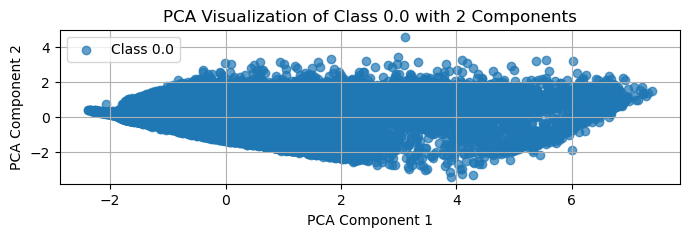

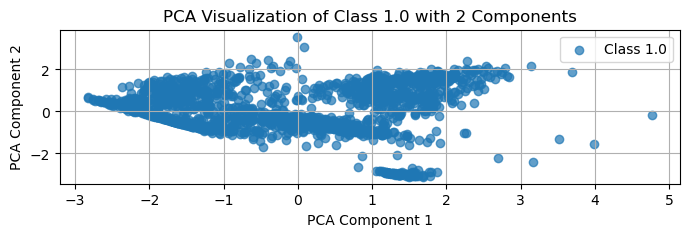

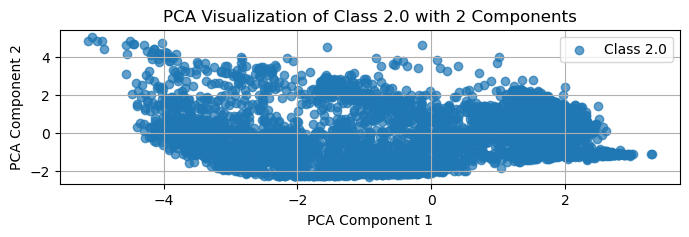

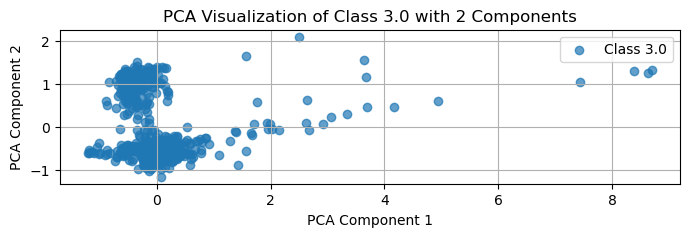

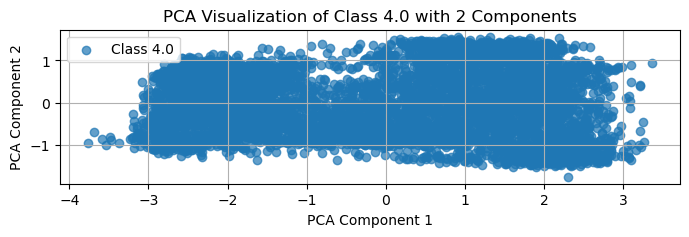

In [5]:
import os
sys.path.append(os.path.abspath('../src'))

from dimensionality_reduction import DimensionalityReductionVisualization
# Initialize the visualization class with the label column as the last column
# Define a custom component map for each class
n_components_map = {
    3: 2,  # Class 3 with 3 components
    1: 2,  # Class 1 with 2 components
    2: 2,   # Class 2 with 4 components (optional example)
    4: 2,
    0: 2
}
viz = DimensionalityReductionVisualization(label_column=df_train.columns[-1])

# Plot PCA visualization for all classes individually
viz.plot_all_classes(df_train, method='pca', n_components_map=n_components_map)

## t-sne: 

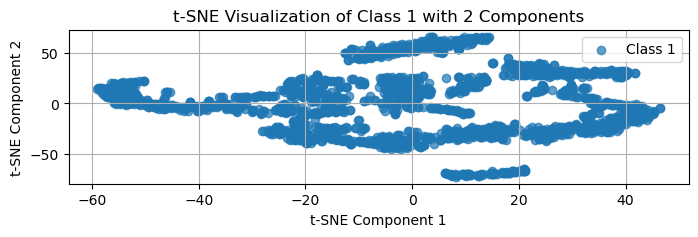

In [6]:
viz.plot_tsne(df_train, target_class=1, n_components=2)

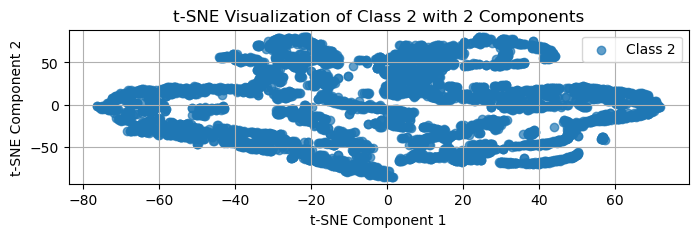

In [7]:
viz.plot_tsne(df_train, target_class=2, n_components=2)

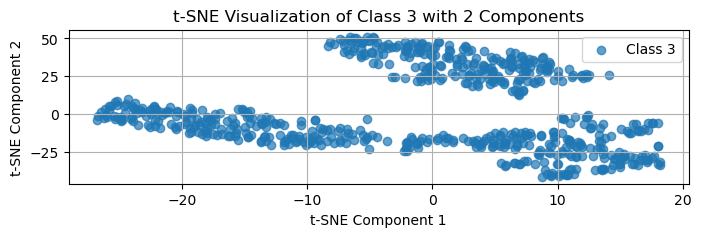

In [8]:
viz.plot_tsne(df_train, target_class=3, n_components=2)

## Seperate Train, test and hold-out set

In [9]:
import sys

# Add the 'src' directory to the Python path so we can import custom utility functions
sys.path.append("../src")  

# Import the stratified sampling function from utils.py
from utils import stratified_sample  


df_validation , df_train = stratified_sample(df_train, 3)

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_validation = df_validation.iloc[:, :-1]
y_validation = df_validation.iloc[:,-1]

# Identify the distribution of classes in the training set
class_distribution = y_train.value_counts().sort_values()

# Select the three least represented classes (minority classes)
minority_classes = class_distribution.index[:3]

# Print the identified minority classes
print(f"Minority classes: {minority_classes.tolist()}")

# Display the class distribution in the training set
# This helps assess dataset imbalance and decide on augmentation strategies
print("Class distribution in the training set:")
print(class_distribution)


Minority classes: [3.0, 1.0, 2.0]
Class distribution in the training set:
187
3.0      641
1.0     2223
2.0     5788
4.0     6431
0.0    69846
Name: count, dtype: int64


In [10]:
X_test, X_holdout, y_test, y_holdout = train_test_split(
    df_test.iloc[:, :-1],  # Features from test set
    df_test.iloc[:, -1],   # Labels from test set
    test_size=0.5,         # 50% of test data goes into the holdout set
    random_state=42        # Ensure reproducibility
)

In [11]:
# Print the class distribution in the validation set
# This helps verify that stratified sampling preserved the class balance
print(y_validation.value_counts())

# Print the class distribution in the training set
# Ensures we have a clear understanding of how many samples exist for each class
print(y_train.value_counts())

187
0.0    525
3.0    525
2.0    525
4.0    525
1.0    525
Name: count, dtype: int64
187
0.0    69846
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [12]:
# Identify the minority classes
class_distribution = y_train.value_counts().sort_values()
minority_classes = class_distribution.index[:3]
print(f"Minority classes: {minority_classes.tolist()}")
print("Class distribution in the training set:")
print(class_distribution)

Minority classes: [3.0, 1.0, 2.0]
Class distribution in the training set:
187
3.0      641
1.0     2223
2.0     5788
4.0     6431
0.0    69846
Name: count, dtype: int64


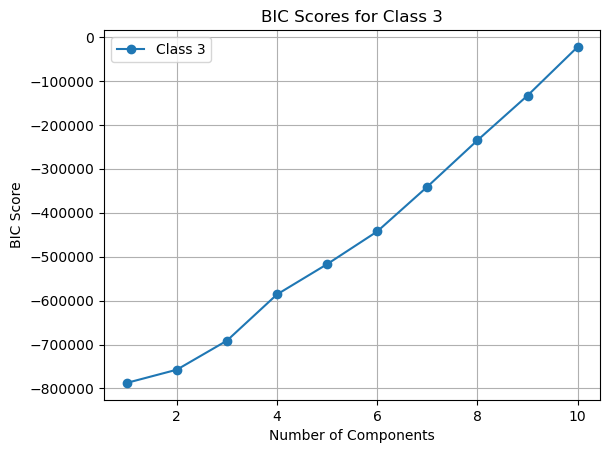

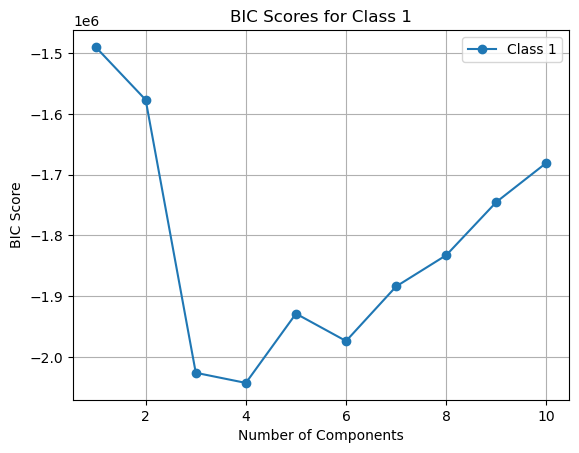

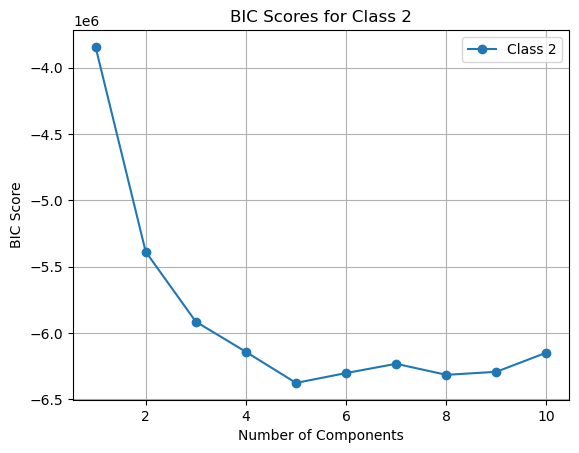

In [13]:
# Import the function to compute BIC scores for a single class
from utils import compute_bic_for_one_class

# Perform BIC analysis for class 3
class_label = 3  # Specify the class label to analyze
bic_scores = compute_bic_for_one_class(df_train, class_label, label_column=df_train.columns[-1])  
# Computes BIC scores for different Gaussian Mixture Model (GMM) components to determine the optimal number

# Perform BIC analysis for class 1
class_label = 1  # Specify the class label to analyze
bic_scores = compute_bic_for_one_class(df_train, class_label, label_column=df_train.columns[-1])  
# The model will fit GMMs with different components and return their BIC scores

# Perform BIC analysis for class 2
class_label = 2  # Specify the class label to analyze
bic_scores = compute_bic_for_one_class(df_train, class_label, label_column=df_train.columns[-1])  
# Helps to find the best number of components for representing the class distribution


## Generate Synthetic Data with Different Samples per Class:

In [14]:
#%%  
# Define target sample sizes for each minority class
class_sample_map = {
    3.0: 6000,  # Generate 15000 samples for class 3.0
    1.0: 4000,  # Generate 13000 samples for class 1.0
    2.0: 1500  # Generate 7500 samples for class 2.0
}

# Optionally, define custom GMM components for each class
n_components_map = {
    3.0: 2,  # Use 3 components for class 3.0
    1.0: 4,  # Use 5 components for class 1.0
    2.0: 5   # Use 4 components for class 2.0
}

## Import the GMM data augmentation function


In [15]:
# Import the GMM data augmentation function
from generate_synthetic_data_gmm import GenerateSyntheticDataGmm

# Generate synthetic data for the specified classes
X_synthetic, y_synthetic = GenerateSyntheticDataGmm(
    pd.concat([X_train, y_train], axis=1),
    class_sample_map=class_sample_map,
    n_components_map=n_components_map
)
print(f"Generated {X_synthetic.shape[0]} synthetic samples for classes {list(class_sample_map.keys())}")

Generated 11500 synthetic samples for classes [3.0, 1.0, 2.0]


In [16]:
# Combine the generated synthetic features (X_synthetic) with their corresponding labels (y_synthetic)
synthetic_data = pd.concat([X_synthetic, y_synthetic], axis=1, ignore_index=True)  

# `axis=1` ensures that the features and labels are combined as columns (side by side).
# `ignore_index=True` resets the index to avoid any inconsistencies after concatenation.

In [17]:
# Extract the feature values from the synthetic dataset 
X_synthetic = synthetic_data.iloc[:, :-1]  # Select all columns except the last one (features)

# Extract the corresponding class labels from the synthetic dataset
y_synthetic = synthetic_data.iloc[:, -1]  # Select only the last column (labels)

# At this point, X_synthetic contains the generated feature data,
# and y_synthetic contains the corresponding class labels.
# This allows us to analyze the distribution of synthetic labels or integrate them into training.

## Plot the generated data 

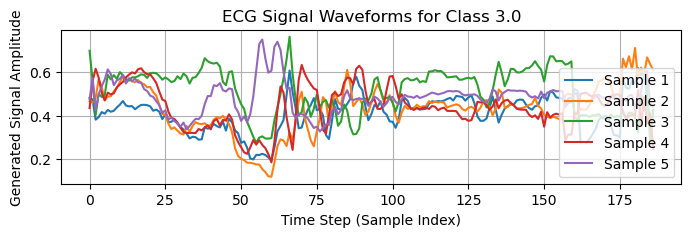

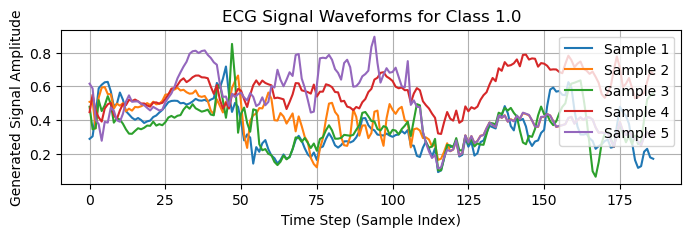

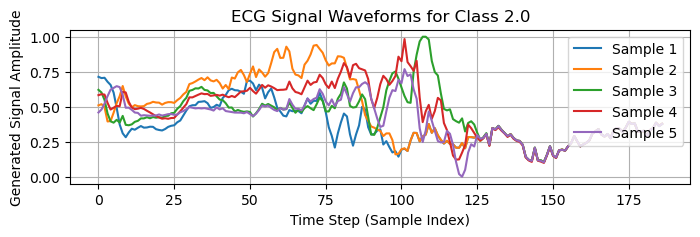

In [18]:
# Loop through each unique class label in the synthetic dataset
for label in synthetic_data.iloc[:, -1].unique():
    
    # Create a new figure for the current class
    plt.figure(figsize=(8, 2))
    
    # Select 5 random synthetic signals that belong to the current class
    sample_signals = synthetic_data[synthetic_data.iloc[:, -1] == label].iloc[:, :-1].sample(5, random_state=42)
    
    # Iterate through the selected signals and plot them
    for i, signal in enumerate(sample_signals.values):
        plt.plot(signal, label=f"Sample {i+1}")  # Plot each signal and label it
    
    # Set labels and title for better readability
    plt.xlabel('Time Step (Sample Index)')  # X-axis represents the time steps of the ECG signal
    plt.ylabel('Generated Signal Amplitude')  # Y-axis represents the amplitude of the generated ECG signal
    plt.title(f'ECG Signal Waveforms for Class {label}')  # Title indicating which class the signals belong to
    
    # Add legend and grid for better visualization
    plt.legend()
    plt.grid(True)
    
    # Save the figure as a high-resolution PNG file for documentation purposes
    plt.savefig(f'ECG_Signal_Waveforms_for_Class_{label}.png', bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()

In [19]:
import pandas as pd

# Combine the original training features with the newly generated synthetic samples
X_train_augmented = pd.concat([X_train, X_synthetic], axis=0, ignore_index=True)

# Combine the original training labels with the corresponding synthetic labels
y_train_augmented = pd.concat([y_train, y_synthetic], axis=0, ignore_index=True)

# Print the new size of the training set after augmentation
print(f"New training set size after GMM augmentation: {X_train_augmented.shape[0]}")

# Print the number of labels to confirm that the dataset remains aligned
print(f"Number of labels in augmented set: {y_train_augmented.shape[0]}")

New training set size after GMM augmentation: 96429
Number of labels in augmented set: 96429


## Preparing the data for training: 

In [20]:
#%% Prepare Data

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from cnn_lstm_classifier import CNNLSTMClassifier  # Import the CNN-LSTM model class from the src directory

# Add a channel dimension to the input data to make it compatible with CNN layers
X_data = np.expand_dims(X_train_augmented.values, axis=-1)

# Extract the corresponding labels
y_data = y_train_augmented.values

# Print the input shape to verify it matches the model's expected format
print(f"Input shape for model: {X_data.shape}")  # Expected shape: (num_samples, num_features, 1)

# Print the label shape to confirm the dataset is correctly structured
print(f"Labels shape: {y_data.shape}")  # Expected shape: (num_samples,)


Input shape for model: (96429, 187, 1)
Labels shape: (96429,)


## Training: 

In [21]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from data_augmentation import DataAugmentation  # Assuming the class is in the src folder
from cnn_lstm_classifier import CNNLSTMClassifier  # Assuming the model class is in the src directory

# Initialize Data Augmentation class
augmenter = DataAugmentation(
    shift_max=5, 
    noise_level=0.01, 
    scale_range=(0.9, 1.1)
)

# Define the augmentation factor (e.g., 0.5, 1, 2, etc.)
augmentation_factor = 0.5  # You can adjust this value as needed

# 🆕 Apply data augmentation to the entire dataset before splitting
X_augmented = augmenter.augment_batch(X_data, augmentation_factor=augmentation_factor)

print("Data generated ...")

# Calculate the correct number of labels for the augmented samples
num_original_samples = len(y_data)
num_augmented_samples = X_augmented.shape[0]

# Generate the correct number of labels for the augmented samples
y_augmented = np.repeat(y_data, np.ceil(num_augmented_samples / num_original_samples).astype(int))[:num_augmented_samples]

# Combine original and augmented data
X_combined = np.vstack((X_data, X_augmented))
y_combined = np.concatenate((y_data, y_augmented))

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(X_combined.shape[0])
X_combined = X_combined[shuffle_indices]
y_combined = y_combined[shuffle_indices]

print(f"Combined dataset size: {X_combined.shape[0]}")

# To store evaluation metrics
accuracy_scores = []
classification_reports = []
confusion_matrices = []


Data generated ...
Combined dataset size: 192858


## Initialize the model and training : 

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
import numpy as np
import seaborn as sns

# Initialize the CNN + LSTM model
model = CNNLSTMClassifier(
    input_shape=(187, 1),  # The input shape is already correctly set
    num_classes=len(np.unique(y_combined)),
    learning_rate=1e-3,
    batch_size=32,
    epochs=50
)

# Train the model with the combined data
print("\nStarting model training...")
model.fit(X_combined, y_combined, X_validation, y_validation)


Starting model training...
Epoch 1/50
6023/6027 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8450 - loss: 0.5708
Epoch 1: val_accuracy improved from inf to 0.52419, saving model to saved_model.h5


6027/6027 ━━━━━━━━━━━━━━━━━━━━ 72s 12ms/step - accuracy: 0.8450 - loss: 0.5707 - val_accuracy: 0.5242 - val_loss: 1.8958 - learning_rate: 0.0010
Epoch 2/50
6025/6027 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9271 - loss: 0.2932
Epoch 2: val_accuracy did not improve from 0.52419
6027/6027 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step - accuracy: 0.9271 - loss: 0.2932 - val_accuracy: 0.5265 - val_loss: 1.6786 - learning_rate: 0.0010
Epoch 3/50
6024/6027 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9379 - loss: 0.2377
Epoch 3: val_accuracy did not improve from 0.52419
6027/6027 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step - accuracy: 0.9379 - loss: 0.2377 - val_accuracy: 0.5432 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 4/50
6024/6027 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9443 - loss: 0.2073
Epoch 4: val_accuracy did not improve from 0.52419
6027/6027 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.9443 - loss: 0.2073 - val_accuracy: 0.6804 - val_loss: 1.0470 - learning_rate: 0.0010


## Plot 

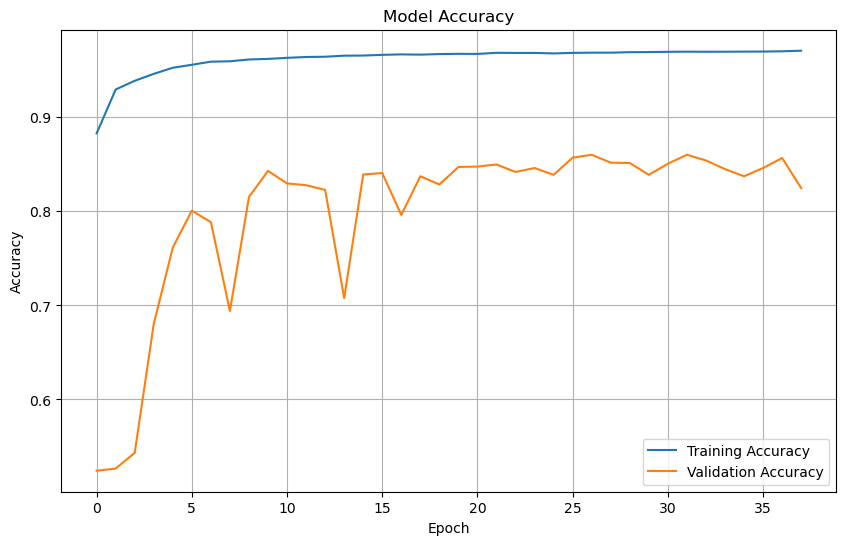


Evaluating on Validation Set...
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.31      1.00      0.47       525
         1.0       0.94      0.09      0.16       525
         2.0       0.92      0.62      0.74       525
         3.0       0.00      0.00      0.00       525
         4.0       0.98      0.91      0.94       525

    accuracy                           0.52      2625
   macro avg       0.63      0.52      0.46      2625
weighted avg       0.63      0.52      0.46      2625



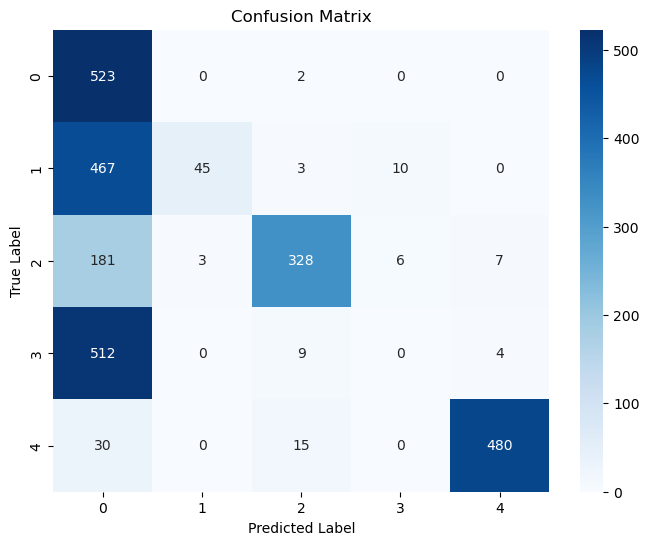

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Validation Accuracy: 0.5242

Classification Report:
              precision    recall  f1-score   support

         0.0     0.3053    0.9962    0.4674       525
         1.0     0.9375    0.0857    0.1571       525
         2.0     0.9188    0.6248    0.7438       525
         3.0     0.0000    0.0000    0.0000       525
         4.0     0.9776    0.9143    0.9449       525

    accuracy                         0.5242      2625
   macro avg     0.6278    0.5242    0.4626      2625
weighted avg     0.6278    0.5242    0.4626      2625


Confusion Matrix:
[[523   0   2   0   0]
 [467  45   3  10   0]
 [181   3 328   6   7]
 [512   0   9   0   4]
 [ 30   0  15   0 480]]


In [23]:
# Plot the accuracy and loss curves using the built-in method
model.plot_history()

# Evaluate the model using the validation set
print("\nEvaluating on Validation Set...")
model.evaluate(X_validation, y_validation)

# Load the best model to make predictions
best_model = keras.models.load_model('saved_model.h5')

# Predict on the validation set using the best model
y_val_pred = best_model.predict(X_validation)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate and display accuracy
accuracy = accuracy_score(y_validation, y_val_pred_classes)
print(f"\nValidation Accuracy: {accuracy:.4f}")

# Generate and display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_validation, y_val_pred_classes, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_val_pred_classes))

## test set

Test set shape: (10946, 187, 1)
Test labels shape: (10946,)
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0     0.9342    0.9962    0.9642      9012
         1.0     0.5946    0.0761    0.1350       289
         2.0     0.8918    0.6340    0.7411       754
         3.0     0.0000    0.0000    0.0000        78
         4.0     0.9775    0.9090    0.9420       813

    accuracy                         0.9334     10946
   macro avg     0.6796    0.5231    0.5565     10946
weighted avg     0.9189    0.9334    0.9184     10946

Accuracy on Test Set: 0.9334


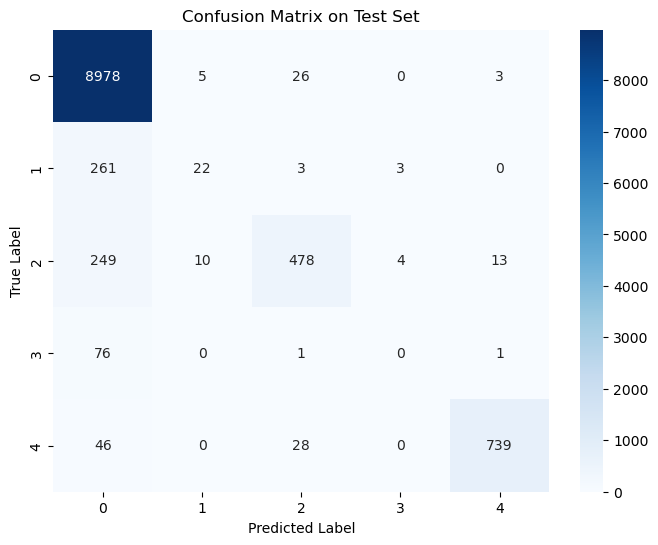

In [24]:
#%% evlauate the model with the test set

# Ensure the test data has the correct shape
X_test = np.expand_dims(X_test, axis=-1)  # Add channel dimension if not already added
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


from tensorflow import keras

# Load the best model weights
best_model = keras.models.load_model('saved_model.h5')

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Generate classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred_classes, digits=4))

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f"Accuracy on Test Set: {test_accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig("Confusion Matrix on Test Set" , bbox_inches='tight', dpi=300)
plt.show()

Prepared holdout set shape for augmentation: (10946, 187, 1)


Noisy holdout set shape: (10946, 187, 1)
Noisy holdout labels shape: (10946,)

Evaluating on the Noisy Holdout Set...
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Noisy Holdout Set Accuracy: 0.9379

Classification Report for Noisy Holdout Set:
              precision    recall  f1-score   support

         0.0     0.9378    0.9967    0.9664      9106
         1.0     0.7931    0.0861    0.1554       267
         2.0     0.8974    0.6427    0.7490       694
         3.0     0.0000    0.0000    0.0000        84
         4.0     0.9796    0.9069    0.9419       795

    accuracy                         0.9379     10946
   macro avg     0.7216    0.5265    0.5625     10946
weighted avg     0.9275    0.9379    0.9236     10946



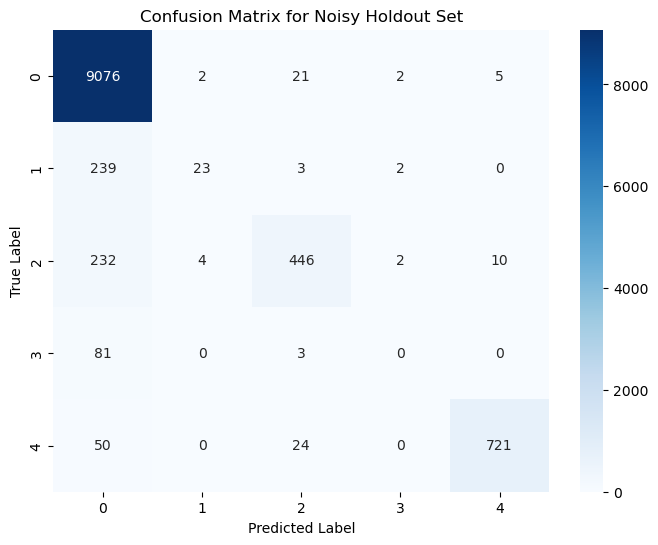

In [25]:
import numpy as np
from data_augmentation import DataAugmentation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

# Initialize the Data Augmentation class for noise injection
augmenter = DataAugmentation(
    shift_max=0,       # No time shift
    noise_level=0.1,   # Introduce significant noise
    scale_range=(1.0, 1.0), # No scaling
    expected_length=187
)

# 🆕 Prepare holdout data with the channel dimension for augmentation
X_holdout_prepared = np.expand_dims(X_holdout, axis=-1)  # Shape should be (samples, 187, 1)
y_holdout = y_holdout

#%%
print(f"Prepared holdout set shape for augmentation: {X_holdout_prepared.shape}")

# Apply noise to the holdout set with an augmentation factor of 1 (100% of samples)
X_holdout_noisy = augmenter.augment_batch(X_holdout_prepared, augmentation_factor=1.0)

# 🆕 Set the labels for the augmented noisy holdout set
num_original_samples = len(y_holdout)
num_augmented_samples = X_holdout_noisy.shape[0]

# Generate the correct number of labels for the augmented samples
y_holdout_noisy = np.repeat(y_holdout, np.ceil(num_augmented_samples / num_original_samples).astype(int))[:num_augmented_samples]

print(f"Noisy holdout set shape: {X_holdout_noisy.shape}")
print(f"Noisy holdout labels shape: {y_holdout_noisy.shape}")

# Load the best model
model = keras.models.load_model('saved_model.h5')

# Evaluate on the noisy holdout set
print("\nEvaluating on the Noisy Holdout Set...")
y_holdout_pred = model.predict(X_holdout_noisy)
y_holdout_pred_classes = np.argmax(y_holdout_pred, axis=1)

# Calculate accuracy for the noisy holdout set
holdout_accuracy = accuracy_score(y_holdout_noisy, y_holdout_pred_classes)
print(f"Noisy Holdout Set Accuracy: {holdout_accuracy:.4f}")

# Generate classification report for the noisy holdout set
print("\nClassification Report for Noisy Holdout Set:")
print(classification_report(y_holdout_noisy, y_holdout_pred_classes, digits=4))

# Generate confusion matrix for the noisy holdout set
conf_matrix_holdout = confusion_matrix(y_holdout_noisy, y_holdout_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_holdout, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Noisy Holdout Set')
plt.savefig('Confusion Matrix for Noisy Holdout Set' , bbox_inches='tight', dpi=300)
plt.show()